In [20]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import datetime
#graphing
import matplotlib.pyplot as plt
#stats
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel

#import testing
import sys
sys.path.append("../")
import selection_tests

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
#format the bus .dat from augirregabiria and mira's website
data = np.fromfile('bus1234.dat')
data = data.reshape(int(len(data)/6),6)
data = pd.DataFrame(data,columns=['id','group','year','month','replace','miles'])

#save to .csv
data.to_csv('bus1234.csv')

#divide by 1e6 (use the same scale are Rust and AM)
data['miles'] = (data['miles'])/1e6

#switch to date time for ease 
data['date'] = pd.to_datetime(data[['year', 'month']].assign(Day=1))
data = data[['id','group','date','replace','miles']]

#lag date
date_lag = data.copy()
date_lag['date'] = date_lag['date'] - pd.DateOffset(months=1)
data = data.merge(date_lag, how='left', on=['id','group','date'] , suffixes=('','_next'))
data = data.dropna()

In [22]:
linear_cost = lambda params, x, i: (1-i)*x*params[i] + i*params[i]
linear_model = selection_tests.CCP(data['replace'], data['miles'], data['miles_next'], ['theta1','RC'],
                                   linear_cost,.9999)
logit_model = selection_tests.CCP(data['replace'], data['miles'], data['miles_next'], ['theta1','RC'],
                                   linear_cost,0)
p_linear = selection_tests.hm_prob(linear_model.results.params, linear_model.cost, linear_model.pr_obs,
                                linear_model.trans, linear_model.states,.9999)

p_logit = selection_tests.hm_prob(logit_model.results.params, logit_model.cost, logit_model.pr_obs,
                                logit_model.trans, linear_model.states,0)

Optimization terminated successfully.
         Current function value: 0.036542
         Iterations: 64
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: 0.037276
         Iterations: 71
         Function evaluations: 139


In [23]:
pr_data = np.zeros(linear_model.states.shape)
for i in range(linear_model.states.shape[0]):
    pr_replace = data['replace'][data['miles'] >=linear_model.states[i]]
    pr_data[i] = pr_replace.sum()/pr_replace.shape[0]

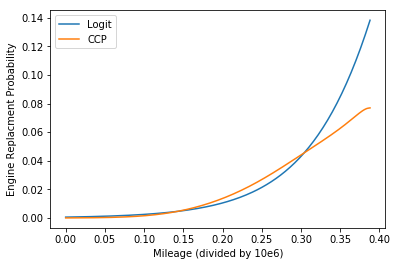

In [24]:
#set up plot of both value functions
fig = plt.figure()

#make a plot of both value functions
plt.ylabel('Engine Replacment Probability')
plt.xlabel('Mileage (divided by 10e6)')
#plt.scatter(linear_model.states, pr_data,label='Raw Data')
plt.plot(linear_model.states, p_logit, label='Logit')
plt.plot(linear_model.states, p_linear,label='CCP')

plt.legend()
plt.savefig('rust1.png')
plt.show()